In [59]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('max_rows',1000)
import os
from qvalue import estimate
from glob import iglob

In [60]:
mod2unp = pd.read_csv("modbase2unpac.txt",delimiter='\t')

In [61]:
# Load the ExAC nsSNV results
ns  = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-06-28/modbase_exac/daf_K_summary.txt",delimiter='\t')
ns  = ns.merge(mod2unp,left_on="structid",right_on="modelid")
print "Number of ModBase models evaluated: %d"%len(ns)
wns = ns.copy()
ns  = ns.sort_values(by="Kp").drop_duplicates("unp")
wns = ns.sort_values(by="wKp").drop_duplicates("unp")
print "NUmber of unique proteins analyzed: %d"%len(ns)
# Calculate FDR for un-weighted
ns.ix[~ns[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(ns.ix[~ns[ "Kp"].isnull(), "Kp"].values)
# Calculate FDR for weighted
wns.ix[~wns["wKp"].isnull(),"wKq"],wK_lam,wK_pi = estimate(wns.ix[~wns["wKp"].isnull(),"wKp"].values)

Number of ModBase models evaluated: 59178
NUmber of unique proteins analyzed: 13478


In [62]:
# Load the ClinVar pathogenic results
cv = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-06-21/modbase_clinvar/pathogenic_K_summary.txt",delimiter='\t')
cv = cv.merge(mod2unp,left_on="structid",right_on="modelid")
print "Number of ModBase models evaluated: %d"%len(cv)
cv = cv.sort_values(by="Kp").drop_duplicates("unp")
print "NUmber of unique proteins analyzed: %d"%len(cv)
cv.ix[~cv[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(cv.ix[~cv[ "Kp"].isnull(), "Kp"].values)

Number of ModBase models evaluated: 4298
NUmber of unique proteins analyzed: 1129


In [63]:
# Load the COSMIC somatic results
csm  = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-06-21/modbase_cosmic/recurrence_K_summary.txt",delimiter='\t')
csm  = csm.merge(mod2unp,left_on="structid",right_on="modelid")
wcsm = csm.copy()
print "Number of ModBase models evaluated: %d"%len(csm)
csm  = csm.sort_values(by="Kp").drop_duplicates("unp")
wcsm = wcsm.sort_values(by="wKp").drop_duplicates("unp")
print "NUmber of unique proteins analyzed: %d"%len(csm)
# Calculate FDR for un-weighted
csm.ix[~csm[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(csm.ix[~csm[ "Kp"].isnull(), "Kp"].values)
# Calculate FDR for weighted
wcsm.ix[~wcsm["wKp"].isnull(),"wKq"],wK_lam,wK_pi = estimate(wcsm.ix[~wcsm["wKp"].isnull(),"wKp"].values)

Number of ModBase models evaluated: 100955
NUmber of unique proteins analyzed: 16962


In [79]:
def prep_split(dfx):
    df  = dfx.copy()
    df['fdr']  = 'All (N=%4d)'%len(df)
    dft = dfx[dfx["Kq"]<0.1].copy()
    dft['fdr'] = 'FDR < 0.1 (N=%4d)'%len(dft)
    df = pd.concat((df,dft)).dropna(subset=["Kz"])
    df['dummy'] = ''
    return df

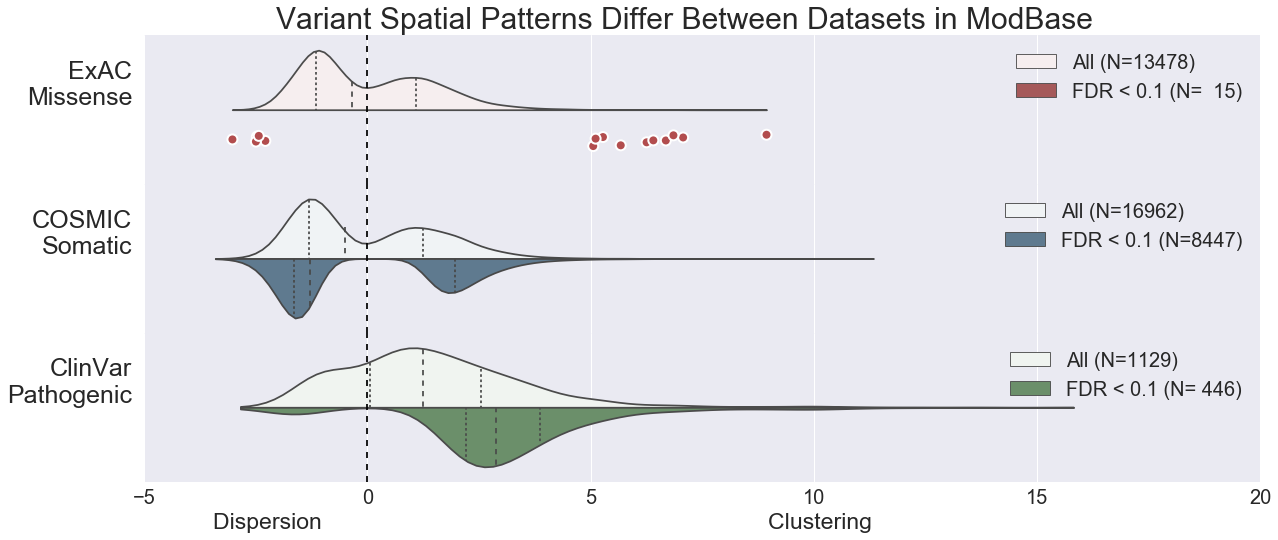

In [80]:
# Setup the plot
fig,ax = plt.subplots(3,1,figsize=(20,8),sharex=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=3, desat=.5))

# Plot the FDR-significant K for ExAC nsSNVs
df = prep_split(ns)
split = (df["Kq"]<0.1).sum()>0
tdf = df.copy()
tdf.ix[tdf['fdr'].str.contains('FDR < 0.1'),'Kz'] = np.nan
sns.violinplot(x='Kz',y='dummy',hue='fdr',data=tdf,inner='quart',color=pal[0],split=split,scale='width',cut=0,ax=ax[0])
df.ix[~df['fdr'].str.contains('FDR < 0.1'),'Kz'] = np.nan
sns.stripplot(x='Kz',y='dummy',hue='fdr',data=df,jitter=True,linewidth=1,color=pal[0],orient='h',split=True,edgecolor='white',size=10,lw=2,ax=ax[0])
ax[0].set_ylabel("ExAC\nMissense",fontsize=25,rotation='horizontal',ha='right')
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(fontsize=20,handles=handles[:2])

# Plot the FDR-significant K for COSMIC somatic nsSNVs
df = prep_split(csm)
split = (df["Kq"]<0.1).sum()>0
sns.violinplot(x='Kz',y='dummy',hue='fdr',data=df,inner='quart',color=pal[1],split=split,scale='width',cut=0,ax=ax[1])
df.ix[~df['fdr'].str.contains('FDR < 0.1'),'Kz'] = np.nan
# sns.stripplot(x='Kz',y='dummy',hue='fdr',data=df,jitter=True,linewidth=1,color=pal[1],orient='h',split=True,edgecolor='white',size=10,lw=2,ax=ax[1])
ax[1].set_ylabel("COSMIC\nSomatic",fontsize=25,rotation='horizontal',ha='right')
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(fontsize=20,handles=handles[:2])

# Plot the FDR-significant K for ClinVar pathogenic nsSNVs
df = prep_split(cv)
split = (df["Kq"]<0.1).sum()>0
sns.violinplot(x='Kz',y='dummy',hue='fdr',data=df,inner='quart',color=pal[2],split=split,scale='width',cut=0,ax=ax[2])
df.ix[~df['fdr'].str.contains('FDR < 0.1'),'Kz'] = np.nan
# sns.stripplot(x='Kz',y='dummy',hue='fdr',data=df,jitter=True,linewidth=1,color=pal[2],orient='h',split=True,edgecolor='white',size=10,lw=2,ax=ax[2])
ax[2].set_ylabel("ClinVar\nPathogenic",fontsize=25,rotation='horizontal',ha='right')
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(fontsize=20,handles=handles[:2])

plt.rcParams['xtick.labelsize'] = 20
plt.xlabel("Dispersion%sClustering%s"%(' '*70,' '*50),fontsize=23)
for x in ax:
    x.axvline(x=0,c='black',ls='dashed')
plt.xlim([-5,20])
plt.suptitle("Variant Spatial Patterns Differ Between Datasets in ModBase",fontsize=30,y=0.95)
plt.show()

In [81]:
def prep_split(dfx):
    df  = dfx.copy()
    df['fdr']  = 'All (N=%4d)'%len(df)
    dft = dfx[dfx["wKq"]<0.1].copy()
    dft['fdr'] = 'FDR < 0.1 (N=%4d)'%len(dft)
    df = pd.concat((df,dft)).dropna(subset=["wKz"])
    df['dummy'] = ''
    return df

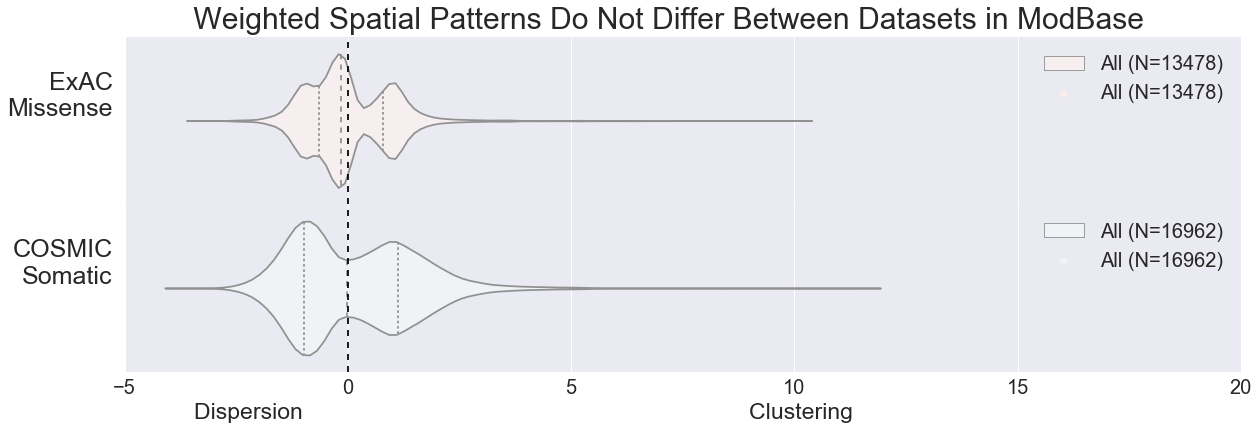

In [84]:
# Setup the plot
fig,ax = plt.subplots(2,1,figsize=(20,6),sharex=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=2, desat=.5))

# Plot the FDR-significant wK for ExAC nsSNVs
df = prep_split(wns)
split = (df["wKq"]<0.1).sum()>0
sns.violinplot(x='wKz',y='dummy',hue='fdr',data=df,inner='quart',color=pal[0],split=split,scale='width',cut=0,ax=ax[0])
df.ix[df['fdr']!='FDR < 0.1','wKz'] = np.nan
sns.stripplot(x='wKz',y='dummy',hue='fdr',data=df,jitter=True,linewidth=1,color=pal[0],orient='h',split=True,edgecolor='white',size=10,lw=2,ax=ax[0])
ax[0].set_ylabel("ExAC\nMissense",fontsize=25,rotation='horizontal',ha='right')
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(fontsize=20,handles=handles[:2])

# Plot the FDR-significant wK for COSMIC somatic nsSNVs
df = prep_split(wcsm)
split = (df["wKq"]<0.1).sum()>0
sns.violinplot(x='wKz',y='dummy',hue='fdr',data=df,inner='quart',color=pal[1],split=split,scale='width',cut=0,ax=ax[1])
df.ix[~df['fdr'].str.contains('FDR < 0.1'),'wKz'] = np.nan
sns.stripplot(x='wKz',y='dummy',hue='fdr',data=df,jitter=True,linewidth=1,color=pal[1],orient='h',split=True,edgecolor='white',size=10,lw=2,ax=ax[1])
ax[1].set_ylabel("COSMIC\nSomatic",fontsize=25,rotation='horizontal',ha='right')
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(fontsize=20,handles=handles[:2])

plt.rcParams['xtick.labelsize'] = 20
plt.xlabel("Dispersion%sClustering%s"%(' '*70,' '*50),fontsize=23)
for x in ax:
    x.axvline(x=0,c='black',ls='dashed')
plt.xlim([-5,20])
plt.suptitle(" Weighted Spatial Patterns Do Not Differ Between Datasets in ModBase",fontsize=30,y=0.97)
plt.show()